# Initial Value Problems

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [41]:
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

In this example, we will solve an initial value problem using the general scalar diffusion equation:

$$\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(-\nu \frac{\partial}{\partial x} \right) = 0$$

If $\nu$, the diffusion coefficient, is assumed to be constant then we have:

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}$$

To solve this equation, we will replace **both** the time and space derivatives with finite differences.  We will use a forward difference for the time derivative and a central difference for the space derivative.  The resulting discretization is:

$$\frac{\partial u}{\partial t}(x=x_j, t=t_n) = \left(u_t\right)_j^n = \frac{u_j^{n+1} - u_j^{n}}{\Delta t}$$

$$\frac{\partial^2 u}{\partial x^2}(x=x_j, t=t_n) = \left(u_{xx}\right)_j^n = \frac{u_{j-1}^{n} - 2u_{j}^{n} + u_{j+1}^{n}}{\Delta x^2}$$

Substituting these into the original PDE, and rearranging for the value of $u$ at the next timestep gives:

$$u_j^{n+1} = u_j^{n} + \frac{\nu \Delta t}{\Delta x^2}\left(u_{j-1}^{n} - 2u_{j}^{n} + u_{j+1}^{n}\right)$$

In this example we'll solve the diffusion equation on a 1D domain with a length of 2

Text(0.5, 1.0, 'Initial condition')

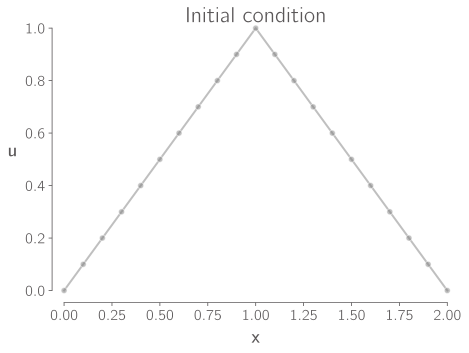

In [42]:
def getInitialCondition(N, L):
    x = jnp.linspace(0, L, N+1)
    return x, 1 - jnp.abs(x-1)

Nx = 20
L = 2.0
dx = L/Nx
tFinal = 0.12
nu = 1.0

x, u0 = getInitialCondition(Nx, L)

fig, ax = plt.subplots()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
ax.plot(x, u0, "-o", color="gray", alpha=0.5, clip_on=False)
niceplots.adjust_spines(ax)
ax.set_title("Initial condition")

In [43]:
def FTCS_solver(u0, nu, dx, dt, T):
    # Initialize the solution array
    u = u0.copy()

    # Define the number of time steps
    num_steps = int(T / dt)

    # Main time-stepping loop
    for _ in range(num_steps):
        # Compute the spatial derivative (centered in space)
        uxx = (jnp.roll(u, 1) - 2 * u + jnp.roll(u, -1))/ (dx**2)
        uxx = uxx.at[jnp.array([0,-1])].set((u[1] - 2 * u[0] + u[-2])/ (dx**2)) 

        # Update the solution using forward time-stepping
        u += nu * uxx * dt
    return u

def computeTimestepFromMu(mu, dx, nu):
    return mu * dx**2 / nu

def plotSolution(ax, x, u0, u, tFinal):
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")

    ax.plot(x, u0, "-o", label=r"$t = 0$", color="gray", alpha=0.5, zorder=0, clip_on=False)
    ax.plot(x, u, "-o", label=f"$t = {tFinal}$", zorder=1, clip_on=False)
    niceplots.adjust_spines(ax, outward=True)
    niceplots.label_line_ends(ax)

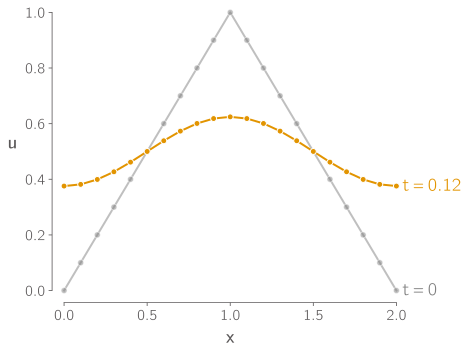

In [46]:
dt = computeTimestepFromMu(0.25, dx, nu)

uFinal = FTCS_solver(u0, nu, dx, dt, tFinal)
fig, ax = plt.subplots()
plotSolution(ax, x, u0, uFinal, tFinal)

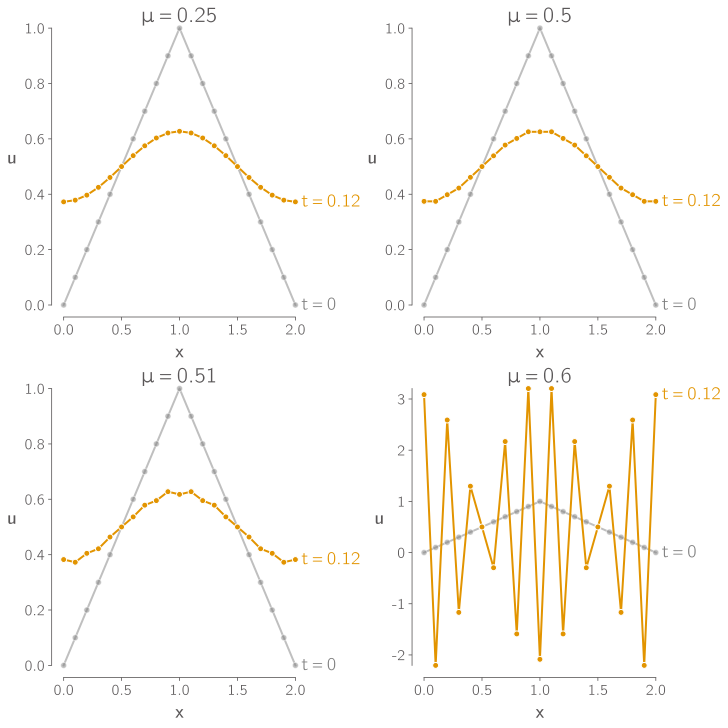

In [45]:

muVals = [0.25, 0.5, 0.51, 0.6]

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 10))

axes = axes.flatten()

for mu, ax in zip(muVals, axes):
    dt = computeTimestepFromMu(mu, dx, nu)
    uFinal = FTCS_solver(u0, nu, dx, dt, tFinal)
    plotSolution(ax, x, u0, uFinal, tFinal)
    ax.set_title(f"$\mu = {mu}$")